You can read an overview of this Numerical Linear Algebra course in [this blog post](http://www.fast.ai/2017/07/17/num-lin-alg/).  The course was originally taught in the [University of San Francisco MS in Analytics](https://www.usfca.edu/arts-sciences/graduate-programs/analytics) graduate program.  Course lecture videos are [available on YouTube](https://www.youtube.com/playlist?list=PLtmWHNX-gukIc92m1K0P6bIOnZb-mg0hY) (note that the notebook numbers and video numbers do not line up, since some notebooks took longer than 1 video to cover).

You can ask questions about the course on [our fast.ai forums](http://forums.fast.ai/c/lin-alg).

# 3. Background Removal with Robust PCA

**Our goal today**: ![background removal](images/surveillance3.png)

## Getting Started

Let's use the real video 003 dataset from [BMC 2012 Background Models Challenge Dataset](http://bmc.iut-auvergne.com/?page_id=24)

Other sources of datasets:
- [Human Activity Video Datasets](https://www.cs.utexas.edu/~chaoyeh/web_action_data/dataset_list.html)
- [Background Subtraction Website](https://sites.google.com/site/backgroundsubtraction/test-sequences) (a few links on this site are broken/outdated, but many work)

Import needed libraries:

In [1]:
import moviepy.editor as mpe
# from IPython.display import display
from glob import glob

In [2]:
import sys, os
import numpy as np
import scipy

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
# MAX_ITERS = 10
TOL = 1.0e-8

In [5]:
video = mpe.VideoFileClip("movie/Video_003.avi")

In [6]:
video.duration

113.57

### Helper Methods

In [7]:
def create_data_matrix_from_video(clip, k=5, scale=50):
    return np.vstack([scipy.misc.imresize(rgb2gray(clip.get_frame(i/float(k))).astype(int), 
                      scale).flatten() for i in range(k * int(clip.duration))]).T

In [8]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [9]:
def plt_images(M, A, E, index_array, dims, filename=None):
    f = plt.figure(figsize=(15, 10))
    r = len(index_array)
    pics = r * 3
    for k, i in enumerate(index_array):
        for j, mat in enumerate([M, A, E]):
            sp = f.add_subplot(r, 3, 3*k + j + 1)
            sp.axis('Off')
            pixels = mat[:,i]
            if isinstance(pixels, scipy.sparse.csr_matrix):
                pixels = pixels.todense()
            plt.imshow(np.reshape(pixels, dims), cmap='gray')
    return f

In [10]:
def plots(ims, dims, figsize=(15,20), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims)
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        plt.imshow(np.reshape(ims[i], dims), cmap="gray")

### Load and view the data

An image from 1 moment in time is 60 pixels by 80 pixels (when scaled). We can *unroll* that picture into a single tall column. So instead of having a 2D picture that is $60 \times 80$, we have a $1 \times 4,800$ column 

This isn't very human-readable, but it's handy because it lets us stack the images from different times on top of one another, to put a video all into 1 matrix.  If we took the video image every tenth of a second for 113 seconds (so 11,300 different images, each from a different point in time), we'd have a $11300 \times 4800$ matrix, representing the video! 

In [11]:
scale = 25   # Adjust scale to change resolution of image
dims = (int(240 * (scale/100)), int(320 * (scale/100)))

In [12]:
M = create_data_matrix_from_video(video, 100, scale)
# M = np.load("high_res_surveillance_matrix.npy")

In [13]:
print(dims, M.shape)

(60, 80) (4800, 11300)


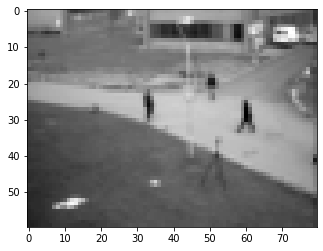

In [14]:
plt.imshow(np.reshape(M[:,140], dims), cmap='gray');

Since `create_data_from_matrix` is somewhat slow, we will save our matrix.  In general, whenever you have slow pre-processing steps, it's a good idea to save the results for future use.

In [15]:
np.save("low_res_surveillance_matrix.npy", M)

Note: High-res M is too big to plot, so only run the below with the low-res version

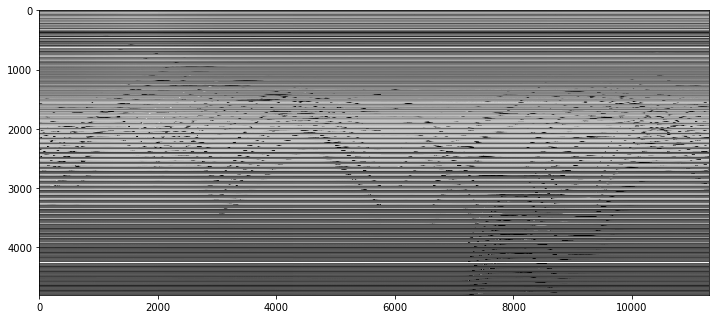

In [16]:
plt.figure(figsize=(12, 12))
plt.imshow(M, cmap='gray')

**Questions**: What are those wavy black lines?  What are the horizontal lines?

In [17]:
plt.imsave(fname="image1.jpg", arr=np.reshape(M[:,140], dims), cmap='gray')

## Principal Component Analysis (PCA)

When dealing with high-dimensional data sets, we often leverage on the fact that the data has **low intrinsic dimensionality** in order to alleviate the curse of dimensionality and scale (perhaps it lies in a low-dimensional subspace or lies on a low-dimensional manifold). [Principal component analysis](http://setosa.io/ev/principal-component-analysis/) is handy for eliminating dimensions.  Classical PCA seeks the best rank-$k$ estimate $L$ of $M$ (minimizing $\| M - L \|$ where $L$ has rank-$k$).  Truncated SVD makes this calculation!

Traditional PCA can handle small noise, but is brittle with respect to grossly corrupted observations-- even one grossly corrupt observation can significantly mess up answer.

**Robust PCA** factors a matrix into the sum of two matrices, $M = L + S$, where $M$ is the original matrix, $L$ is **low-rank**, and $S$ is **sparse**.  This is what we'll be using for the background removal problem! **Low-rank** means that the matrix has a lot of redundant information-- in this case, it's the background, which is the same in every scene (talk about redundant info!).  **Sparse** means that the matrix has mostly zero entries-- in this case, see how the picture of the foreground (the people) is mostly empty.  (In the case of corrupted data, $S$ is capturing the corrupted entries).

### Applications of Robust PCA
- **Video Surveillance**

- **Face Recognition** photos from this excellent [tutorial](https://jeankossaifi.github.io/tensorly/rpca.html).  The dataset here consists of images of the faces of several people taken from the same angle but with different illumniations.

  <img src="images/faces_rpca.png" alt="Robust PCA" style="width: 80%"/>
  ([Source: Jean Kossaifi](https://jeankossaifi.github.io/tensorly/rpca.html))

  <img src="images/faces_rpca_gross.png" alt="Robust PCA" style="width: 80%"/>
  ([Source: Jean Kossaifi](https://jeankossaifi.github.io/tensorly/rpca.html))

- Latent Semantic Indexing: $L$ captures common words used in all documents while $S$ captures the few key words that best distinguish each document from others

- Ranking and Collaborative Filtering: a small portion of the available rankings could be noisy and even tampered with (see [Netflix RAD - Outlier Detection on Big Data](http://techblog.netflix.com/2015/02/rad-outlier-detection-on-big-data.html) on the official netflix blog)

### L1 norm induces sparsity

The unit ball $\lVert x \rVert_1 = 1$ is a diamond in the L1 norm.  It's extrema are the corners:

 <img src="images/L1vsL2.jpg" alt="L1 norm" style="width: 60%"/>
  ([Source](https://www.quora.com/Why-is-L1-regularization-supposed-to-lead-to-sparsity-than-L2))
  
  A similar perspective is to look at the *contours* of the loss function:
 <img src="images/L1vsL2_2.png" alt="L2 norm" style="width: 60%"/>
  ([Source](https://www.quora.com/Why-is-L1-regularization-better-than-L2-regularization-provided-that-all-Norms-are-equivalent))

### Optimization Problem

Robust PCA can be written:

$$ minimize\; \lVert L \rVert_* + \lambda\lVert S \rVert_1 \\ subject\;to\; L + S = M$$
 
where:

- $\lVert \cdot \rVert_1$ is the **L1 norm**.  Minimizing the [L1 norm](https://medium.com/@shiyan/l1-norm-regularization-and-sparsity-explained-for-dummies-5b0e4be3938a) results in sparse values.  For a matrix, the L1 norm is equal to the [maximum absolute column norm](https://math.stackexchange.com/questions/519279/why-is-the-matrix-norm-a-1-maximum-absolute-column-sum-of-the-matrix).

- $ \lVert \cdot \rVert_* $ is the **nuclear norm**, which is the L1 norm of the singular values.  Trying to minimize this results in sparse singular values --> low rank.


### Implementing an algorithm from a paper

#### Source
We will use the general **primary component pursuit algorithm** from this [Robust PCA paper](https://arxiv.org/pdf/0912.3599.pdf) (Candes, Li, Ma, Wright), in the specific form of **Matrix Completion via the Inexact ALM Method** found in [section 3.1 of this paper](https://arxiv.org/pdf/1009.5055.pdf) (Lin, Chen, Ma).  I also referenced the implemenations found [here](https://github.com/shriphani/robust_pcp/blob/master/robust_pcp.py) and [here](https://github.com/dfm/pcp/blob/master/pcp.py).

#### The Good Parts

Section 1 of Candes, Li, Ma, Wright is nicely written, and section 5 Algorithms is our key interest.  **You don't need to know the math or understand the proofs to implement an algorithm from a paper.**  You will need to try different things and comb through resources for useful tidbits.  This field has more theoretical researchers and less pragmatic advice.  It took months to find what I needed and get this working.

The algorithm shows up on page 29:

 <img src="images/pcp_algorithm.png" alt="PCP algorithm" style="width: 100%"/>

needed definitions of $\mathcal{S}$, the Shrinkage operator, and $\mathcal{D}$, the singular value thresholding operator:

 <img src="images/candes.png" alt="PCP algorithm" style="width: 100%"/>

Section 3.1 of [Chen, Lin, Ma]() contains a faster vartiation of this:

 <img src="images/rpca_inexact.png" alt="Inexact RPCA" style="width: 80%"/>

And Section 4 has some very helpful implementation details on how many singular values to calculate (as well as how to choose the parameter values):

 <img src="images/svp_value.png" alt="SVP values" style="width:70%"/> 

### If you want to learn more of the theory:

- Convex Optimization by Stephen Boyd (Stanford Prof): 
  - [OpenEdX Videos](https://www.youtube.com/playlist?list=PLbBM_dvjud8oFj09MqqYnGSrT6zek42Q0)
  - [Jupyter Notebooks](http://web.stanford.edu/~boyd/papers/cvx_short_course.html)
- Alternating Direction Method of Multipliers (more [Stephen Boyd](http://stanford.edu/~boyd/admm.html))

## Robust PCA (via Primary Component Pursuit)

### Methods

We will use [Facebook's Fast Randomized PCA](https://github.com/facebook/fbpca) library.

In [18]:
from scipy import sparse
from sklearn.utils.extmath import randomized_svd
# from sklearn.decomposition import PCA
# import fbpca

In [19]:
TOL=1e-9
MAX_ITERS=3

In [20]:
def converged(Z, d_norm):
    err = np.linalg.norm(Z, 'fro') / d_norm
    print('error: ', err)
    return err < TOL

In [21]:
def shrink(M, tau):
    S = np.abs(M) - tau
    return np.sign(M) * np.where(S>0, S, 0)

In [22]:
# def _svd(M, rank): return fbpca.pca(M, k=min(rank, np.min(M.shape)), raw=True)
def _svd(M, rank):
    k = min(rank, np.min(M.shape))
    U, s, V = np.linalg.svd(M, full_matrices=False)
    U = U[:,:k]
    s = s[:k]
    V = V[:k,:]
    return U,s,V

In [23]:
def norm_op(M): return _svd(M, 1)[1][0]

In [24]:
def svd_reconstruct(M, rank, min_sv):
    u, s, v = _svd(M, rank)
    s -= min_sv
    nnz = (s > 0).sum()
    return u[:,:nnz] @ np.diag(s[:nnz]) @ v[:nnz], nnz

In [25]:
def pcp(X, maxiter=10, k=10): # refactored
    m, n = X.shape
    trans = m<n
    if trans: X = X.T; m, n = X.shape
        
    lamda = 1/np.sqrt(m)
    op_norm = norm_op(X)
    Y = np.copy(X) / max(op_norm, np.linalg.norm( X, np.inf) / lamda)
    mu = k*1.25/op_norm; mu_bar = mu * 1e7; rho = k * 1.5
    
    d_norm = np.linalg.norm(X, 'fro')
    L = np.zeros_like(X); sv = 1
    
    examples = []
    
    for i in range(maxiter):
        print("rank sv:", sv)
        X2 = X + Y/mu
        
        # update estimate of Sparse Matrix by "shrinking/truncating": original - low-rank
        S = shrink(X2 - L, lamda/mu)
        
        # update estimate of Low-rank Matrix by doing truncated SVD of rank sv & reconstructing.
        # count of singular values > 1/mu is returned as svp
        L, svp = svd_reconstruct(X2 - S, sv, 1/mu)
        
        # If svp < sv, you are already calculating enough singular values.
        # If not, add 20% (in this case 240) to sv
        sv = svp + (1 if svp < sv else round(0.05*n))
        
        # residual
        Z = X - L - S
        Y += mu*Z; mu *= rho
        
        examples.extend([S[140,:], L[140,:]])
        
        if m > mu_bar: m = mu_bar
        if converged(Z, d_norm): break
    
    if trans: L=L.T; S=S.T
    return L, S, examples

the algorithm again (page 29 of [Candes, Li, Ma, and Wright](https://arxiv.org/pdf/0912.3599.pdf))

 <img src="images/pcp_algorithm.png" alt="PCP algorithm" style="width: 100%"/>

### Results

In [26]:
m, n = M.shape
round(m * .05)

240

In [27]:
L, S, examples =  pcp(M, maxiter=5, k=10)

rank sv: 1
error:  0.1316379371139465
rank sv: 241
error:  0.04585156858445646
rank sv: 49
error:  0.005828170914815727
rank sv: 289
error:  0.0005537245187954929
rank sv: 529
error:  2.3785173744719035e-05


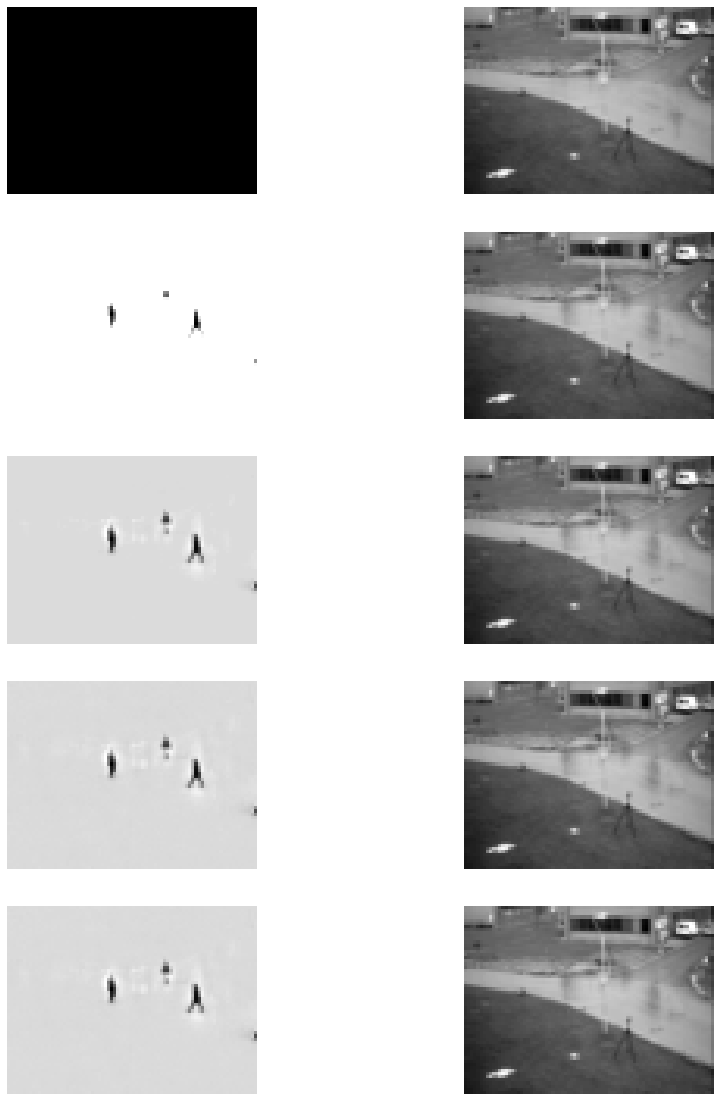

In [28]:
plots(examples, dims, rows=5)

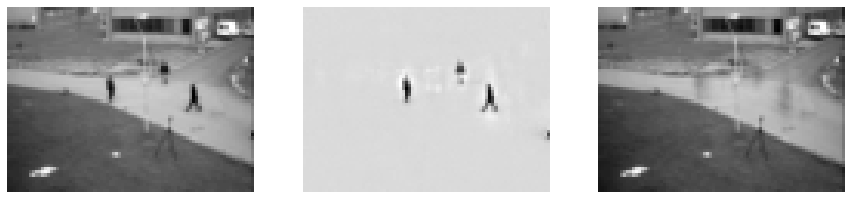

In [29]:
f = plt_images(M, S, L, [140], dims)

In [30]:
np.save("high_res_L.npy", L)
np.save("high_res_S.npy", S)

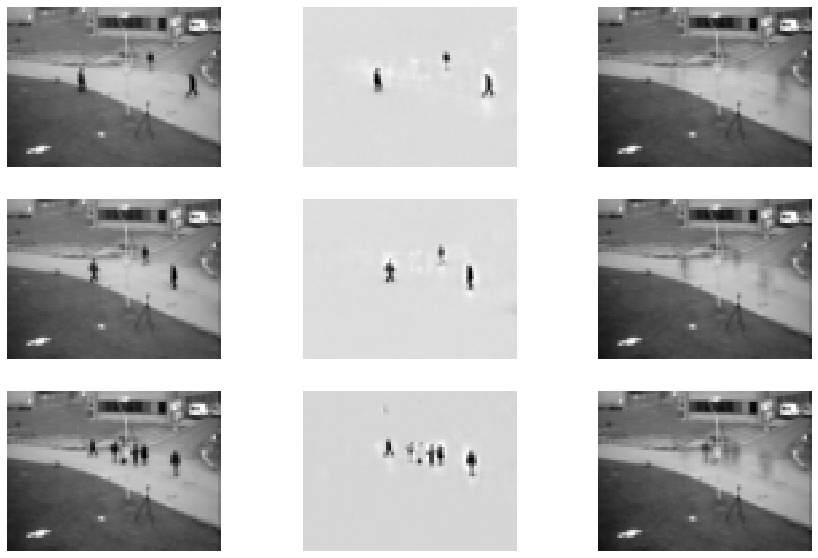

In [32]:
f = plt_images(M, S, L, [0, 100, 1000], dims)

Extracting a bit of the foreground is easier than identifying the background.  To accurately get the background, you need to remove all the foreground, not just parts of it